<b><h1 style="text-align:center;">COMM493 - Coding AI for Business</h1></b>
<h5 style="text-align:center;">K-MEANS CLUSTERING FOR GYM MEMBERSHIP CUSTOMERS</h5>
<h5 style="text-align:center;">INSERT NAMES HERE</h5>
<h5 style="text-align:center;">March 31st, 2025</h5>

### Introduction
**Motivation:** TODO

**Data:** <a href="https://www.kaggle.com/datasets/ka66ledata/gym-membership-dataset/data">gym-membership-dataset</a> 

**Goal:** TODO

### 0: Set Up Environment
Load imports and define constants that will be used to prepare data and train model.

In [1]:
# install mxnet
get_ipython().system('pip install mxnet')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
import boto3

# Data Manipulation
import pandas as pd
import numpy as np
np.bool = bool

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler, TargetEncoder
from sklearn.decomposition import PCA

# Additional Libraries
import tarfile
import mxnet as mx

[03/25/25 18:58:58] INFO     Found credentials from IAM Role:                                   ]8;id=583699;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=619974;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 1: SageMaker Setup & Configuration
ADD INFO HERE

In [2]:
# Initialize a SageMaker Session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')
image_uri = retrieve('kmeans', region)
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/mall/kmeans-all'
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/25/25 18:59:00] INFO     Found credentials from IAM Role:                                   ]8;id=250079;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=21468;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=304044;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=978896;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/25/25 18:59:01] INFO     Found credentials from IAM Role:                                   ]8;id=195681;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=867481;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=813767;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=153045;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=485491;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=155850;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::922202922528:role/LabRole
AWS Region: us-east-1


### 2: Helper Functions
ADD INFO HERE

In [3]:
def time_to_minutes(time_str):
    """Convert time in HH:MM:SS format to minutes."""
    if pd.isna(time_str):
        return 0
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 60 + m
    except ValueError:
        return 0


def cyclical_encode(time_in_minutes):
    """Encode minutes into cyclical sine and cosine features."""
    radians = 2 * np.pi * time_in_minutes / 1440
    return np.sin(radians), np.cos(radians)


def plot_3D(data, labels=None, centroids=None, title=""):
    """Visualize clusters in 3D PCA space with labeled centroids."""
    is_clustered = True
    if (labels is None) or (centroids is None):
        labels = np.zeros(len(data), dtype=int)  # All points in cluster 0
        centroids = np.mean(data, axis=0).reshape(1, -1)  # Global mean as centroid
        title = "3D Visualization (PCA)"
        is_clustered = False

    # Reduce data to 3 dimensions
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data)
    centroids_pca = pca.transform(centroids)

    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique cluster labels and define colors
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster with its respective color
    for i, label in enumerate(unique_labels):
        idx = labels == label
        ax.scatter(data_pca[idx, 0], data_pca[idx, 1], data_pca[idx, 2],
                   color=colors[i], label=f'Cluster {label}', s=50, alpha=0.6)

    # Plot centroids separately with labels
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
               color='red', marker='X', s=200, edgecolor='black', linewidth=1.5, label='Centroids')

    if is_clustered:
        ax.set_title(f'{title}\nSilhouette Score: {silhouette_score(data, labels):.3f}')
    else:
        ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend(title="Clusters", loc="upper right")
    plt.tight_layout()
    plt.show()

### 3: Load and Process Data
Catagorical data is not good for k-means clustering because: Most clustering algorithms rely on Euclidean distance, One-Hot Encoding Explosion (Distances become dominated by the sheer number of columns, diluting meaningful patterns.), No Meaningful "Averages"

Processed Data Preview:
Shape: (1000, 5)
NaN values: 0
Columns: Index(['gender', 'Age', 'abonoment_type', 'visit_per_week',
       'attend_group_lesson', 'avg_time_in_gym', 'drink_abo',
       'personal_training', 'uses_sauna', 'visits_Mon', 'visits_Tue',
       'visits_Wed', 'visits_Thu', 'visits_Fri', 'visits_Sat', 'visits_Sun',
       'fav_group_lesson_bodybalance', 'fav_group_lesson_bodypump',
       'fav_group_lesson_hit', 'fav_group_lesson_kickboxen',
       'fav_group_lesson_lesmiles', 'fav_group_lesson_pilates',
       'fav_group_lesson_running', 'fav_group_lesson_spinning',
       'fav_group_lesson_xcore', 'fav_group_lesson_yoga',
       'fav_group_lesson_zumba', 'fav_drink_berry_boost',
       'fav_drink_black_currant', 'fav_drink_coconut_pineapple',
       'fav_drink_lemon', 'fav_drink_orange', 'fav_drink_passion_fruit',
       'check_in_sin', 'check_in_cos', 'check_out_sin', 'check_out_cos'],
      dtype='object')


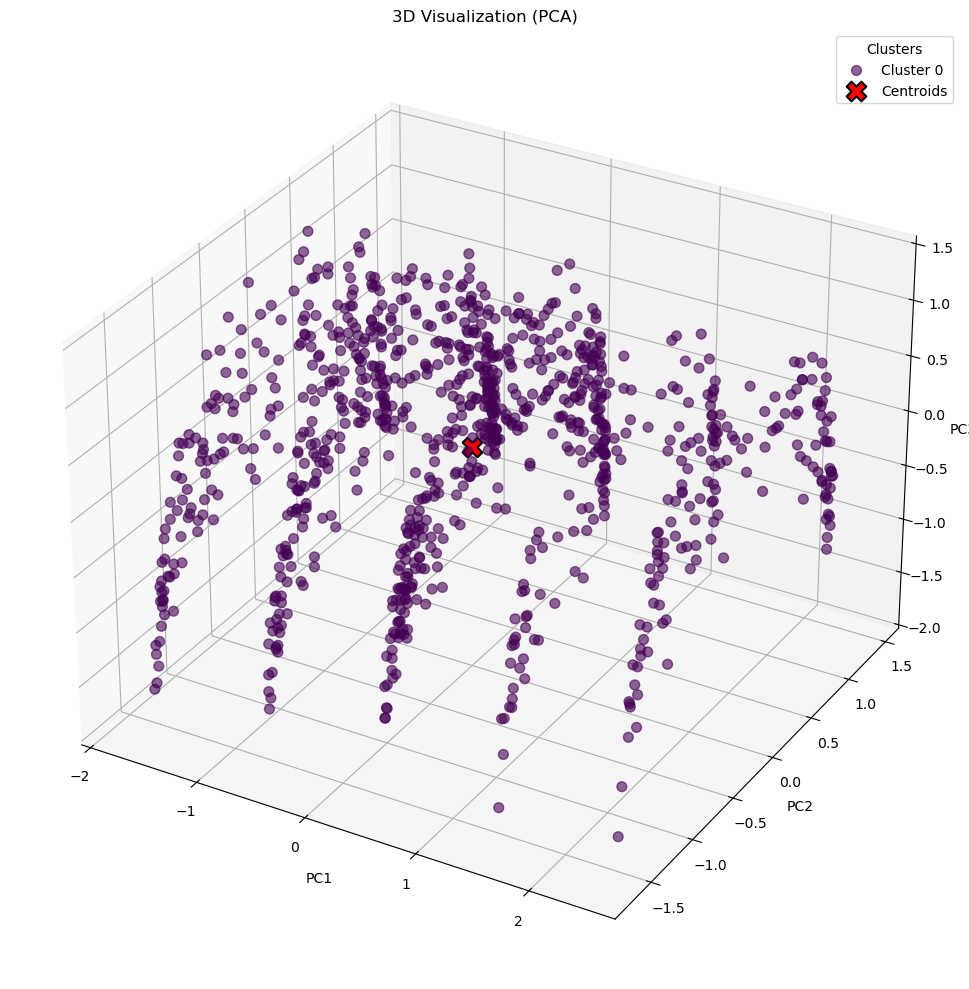

In [4]:
# Load data
df = pd.read_csv('gym_membership.csv')

# Drop irrelevant columns
df.drop(columns=['id', 'birthday', 'name_personal_trainer'], inplace=True)

# Encode 'days_per_week'
df['days_per_week'] = df['days_per_week'].astype(str).fillna('')
for day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
    df[f'visits_{day}'] = df['days_per_week'].apply(lambda x: 1 if day in x else 0)
df.drop('days_per_week', axis=1, inplace=True)

# Clean and encode list-based categoricals
list_categoricals = ['fav_group_lesson', 'fav_drink']
for col in list_categoricals:
    df[col] = df[col].str.replace(' ', '').str.lower().fillna('')
    dummies = df[col].str.get_dummies(sep=',').add_prefix(f'{col}_')
    df = pd.concat([df, dummies], axis=1)
df.drop(columns=list_categoricals, inplace=True)

# convert time to minues
df[['avg_time_check_in', 'avg_time_check_out']] = df[['avg_time_check_in', 'avg_time_check_out']].applymap(time_to_minutes)
# add cyclical features for time columns
df[['check_in_sin', 'check_in_cos']] = df['avg_time_check_in'].apply(
    lambda x: pd.Series(cyclical_encode(x)) if pd.notna(x) else pd.Series([np.nan, np.nan])
)
df[['check_out_sin', 'check_out_cos']] = df['avg_time_check_out'].apply(
    lambda x: pd.Series(cyclical_encode(x)) if pd.notna(x) else pd.Series([np.nan, np.nan])
)
df.drop(columns=['avg_time_check_in', 'avg_time_check_out'], inplace=True)

# Encode binary features
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['abonoment_type'] = df['abonoment_type'].map({'Premium': 1, 'Standard': 0})
bool_cols = ['attend_group_lesson', 'personal_training', 'uses_sauna', 'drink_abo']
df[bool_cols] = df[bool_cols].astype(int)

# Apply RobustScaler to all numerical features (no outlier removal)
continuous_cols = [
    'Age', 'visit_per_week', 'check_in_sin', 'check_in_cos',
    'check_out_sin', 'check_out_cos', 'avg_time_in_gym'
]
df[continuous_cols] = RobustScaler().fit_transform(df[continuous_cols])

# data_np = df.values.astype('float32')
pca = PCA(n_components=0.95)  # Retain 95% variance
data_np = pca.fit_transform(df[continuous_cols]).astype('float32')

# preview
print("Processed Data Preview:")
print(f"Shape: {data_np.shape}")
print(f"NaN values: {df.isna().sum().sum()}")
print(f"Columns: {df.columns}")
plot_3D(data_np)

### 4: Perform k-Means Clustering (k=2,3,...,6)
ADD INFO HERE

In [5]:
k_values = range(2, 9)
training_jobs = []
output_path = f's3://{bucket}/output'

# start training jobs
for k in k_values:
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.xlarge',
        k=k,
        output_path=output_path,
        feature_dim=data_np.shape[1],
        extra_hyperparameters={
            'kmeans_init_method': 'kmeans++',
            'epochs': 100,
            'mini_batch_size': 256,
            'extra_center_factor': 10  # disperse the centroids during initialization,
        }
    )
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# Wait for all jobs to complete
for k, job_name in training_jobs:
    boto3.client('sagemaker').get_waiter('training_job_completed_or_stopped').wait(
        TrainingJobName=job_name)

[03/25/25 18:59:02] INFO     Same images used for training and inference. Defaulting to image     ]8;id=705486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=121365;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=223810;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=77294;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=742476;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=468089;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=977579;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=632982;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-02-383        ]8;id=165912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=652149;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=32738;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=931615;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/25/25 18:59:03] INFO     Ignoring unnecessary instance type: None.                            ]8;id=480738;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=415279;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=491911;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=592441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=880215;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=644234;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-03-141        ]8;id=724113;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=709789;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 18:59:04] INFO     Same images used for training and inference. Defaulting to image     ]8;id=343410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=174386;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=701286;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=213114;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=589250;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=593943;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=853856;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=224297;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-04-283        ]8;id=720734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=212395;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 18:59:06] INFO     Same images used for training and inference. Defaulting to image     ]8;id=942634;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=94853;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=983622;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=292808;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=704368;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=326928;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=419439;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=778820;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-06-889        ]8;id=560;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=29671;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 18:59:07] INFO     Same images used for training and inference. Defaulting to image     ]8;id=526483;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=702072;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/25/25 18:59:08] INFO     Ignoring unnecessary instance type: None.                            ]8;id=976809;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=942161;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=65928;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=917126;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=617849;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=12564;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-08-013        ]8;id=414831;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=516119;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=236680;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=508153;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=885030;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=684041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=180520;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=812318;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=524136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=669225;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-08-796        ]8;id=916133;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=95153;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 18:59:09] INFO     Same images used for training and inference. Defaulting to image     ]8;id=661645;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=71750;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=3087;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=147847;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=191855;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=916100;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=985996;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=619014;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-18-59-09-903        ]8;id=340449;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=554007;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

### 5: Select Best K Value With Sum of Squared Error (SSE) & Silhouette Score
ADD INFO HERE

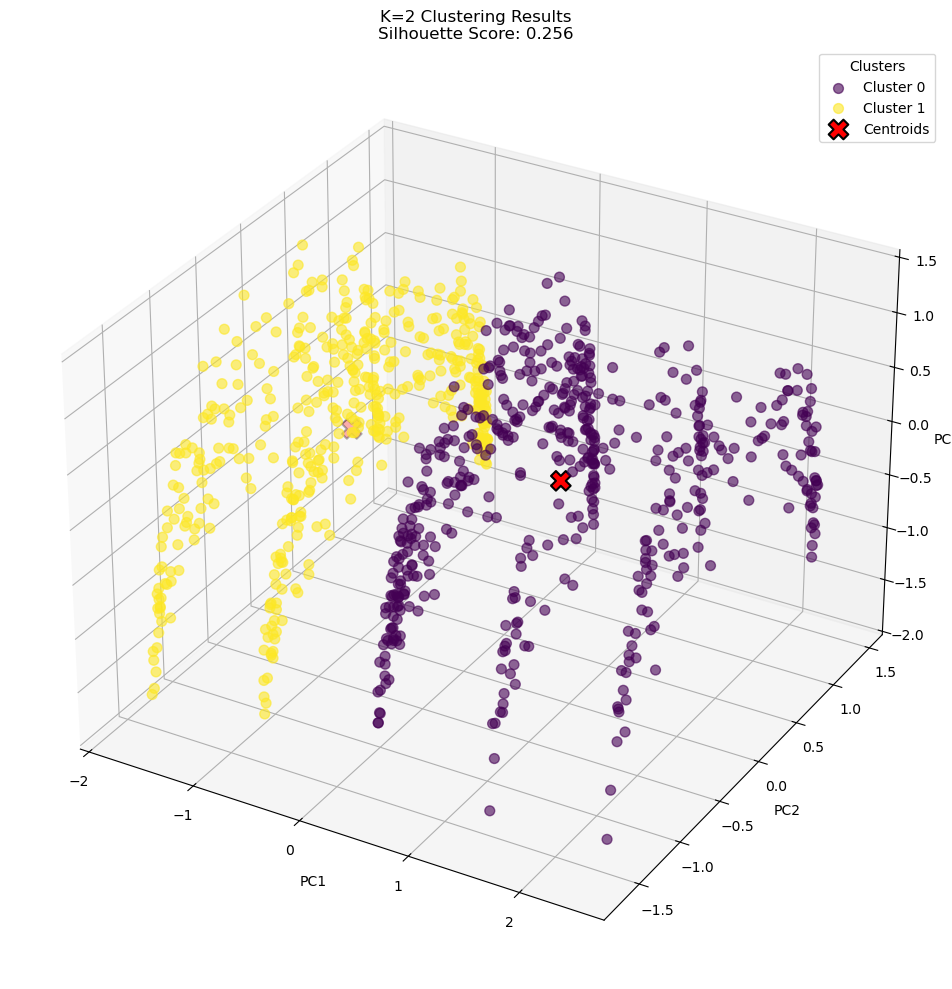

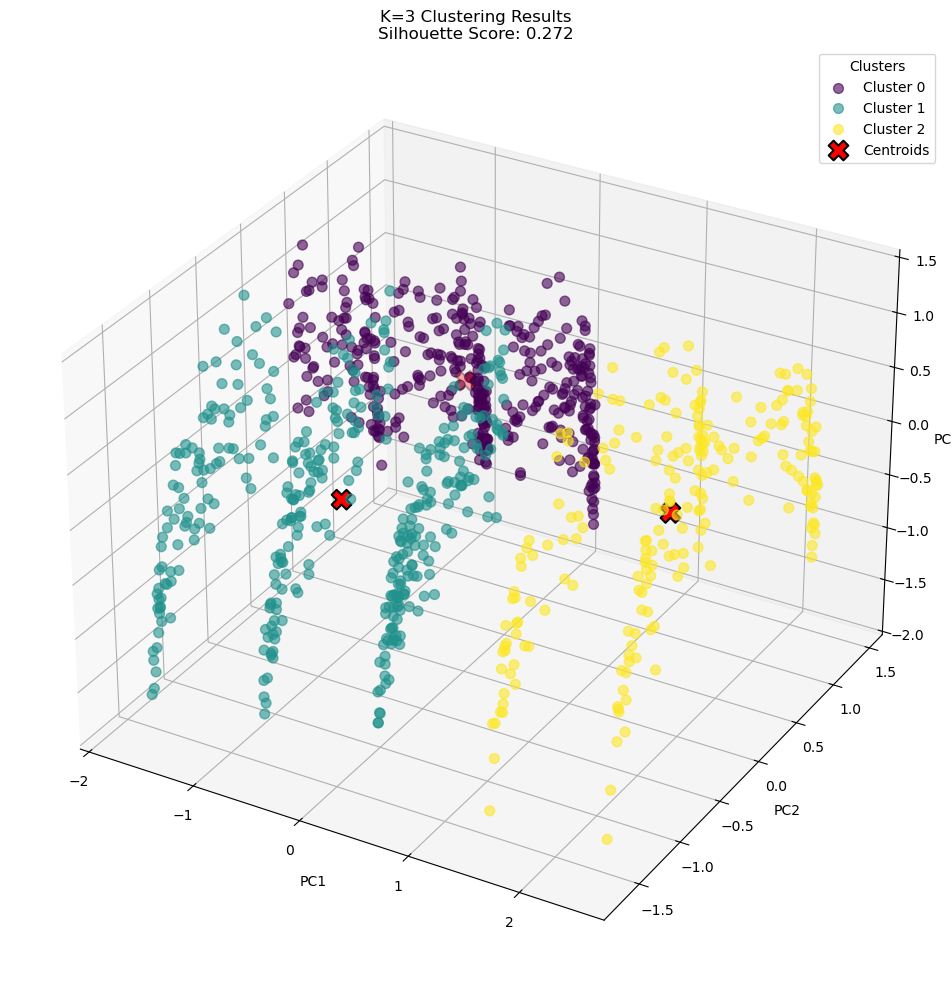

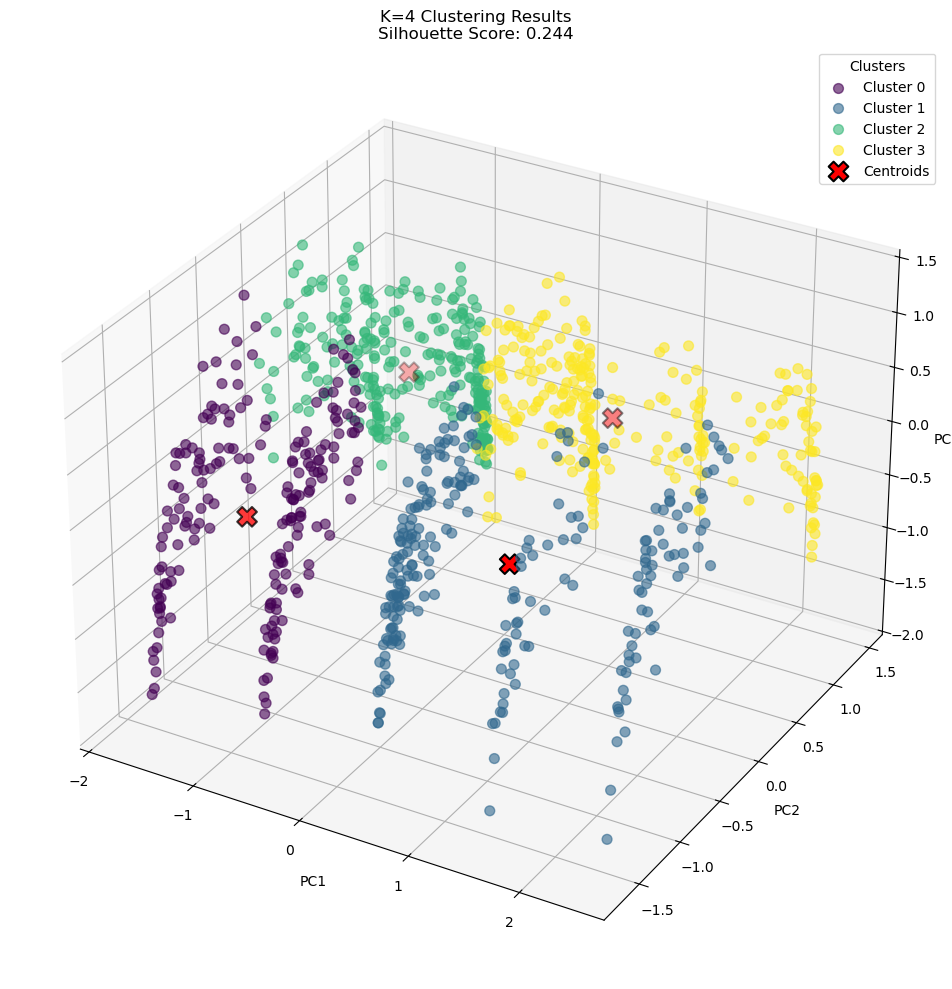

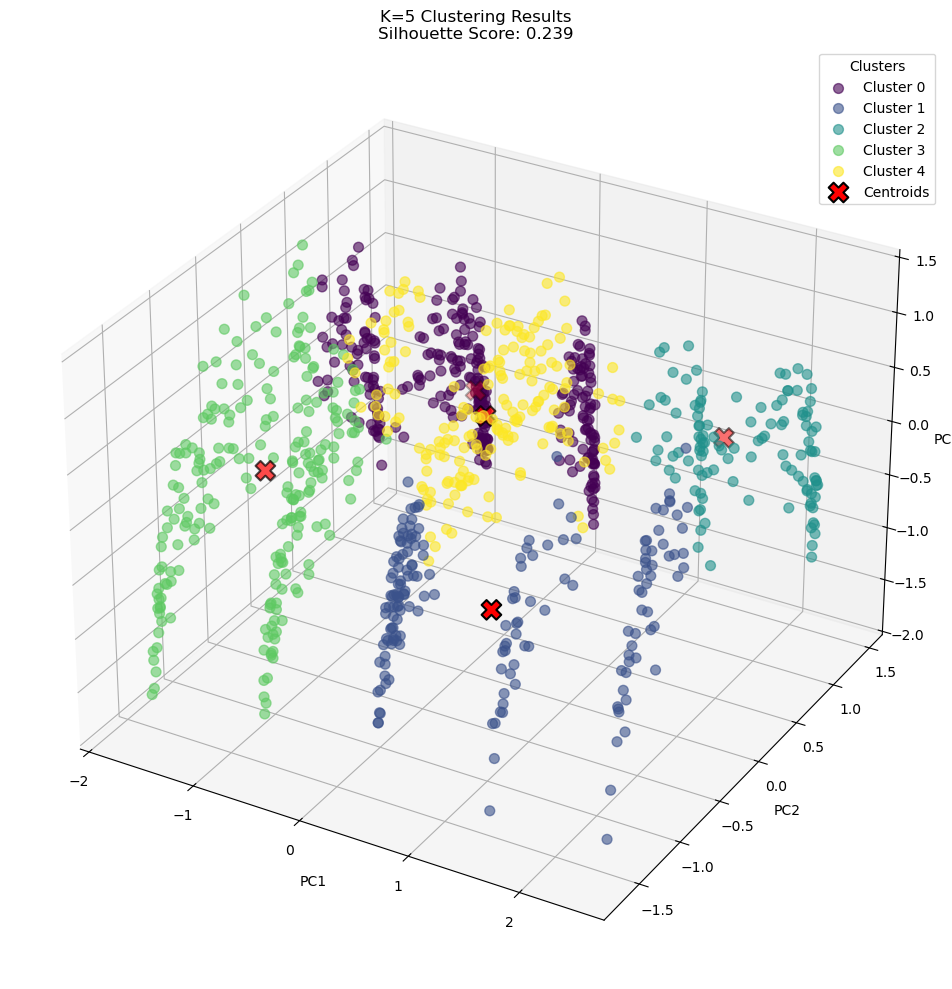

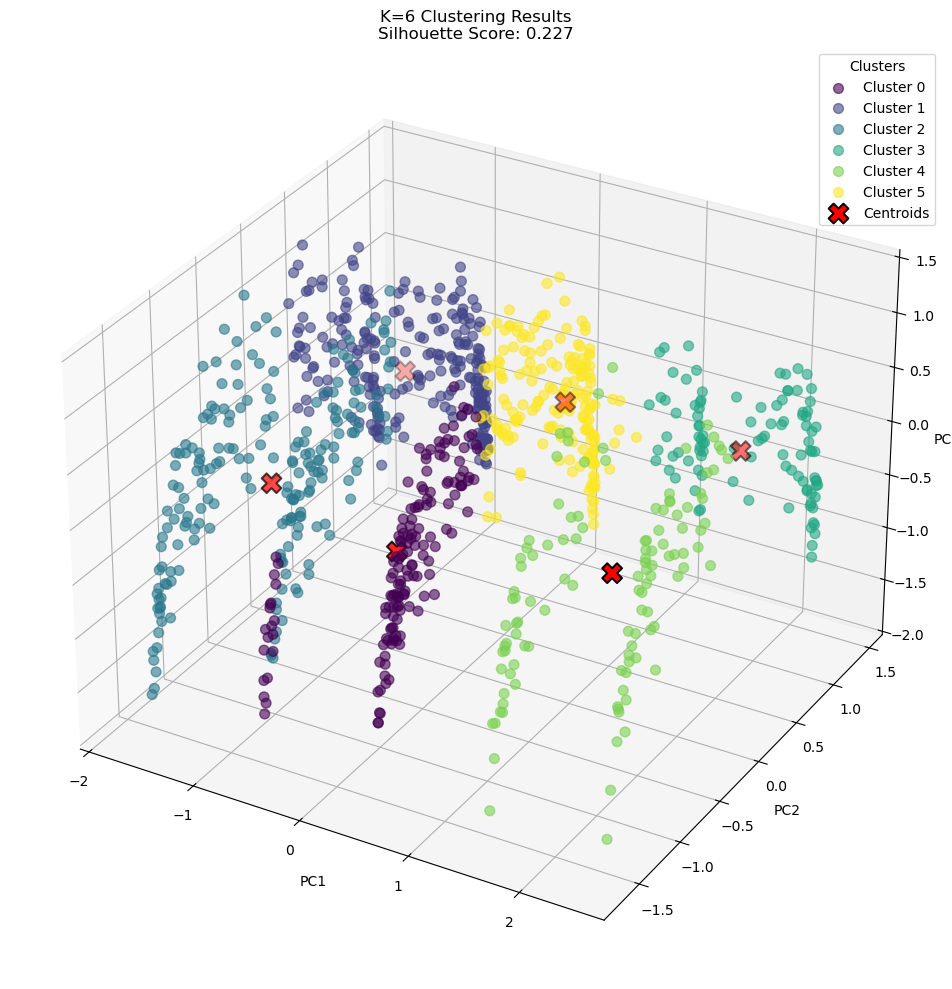

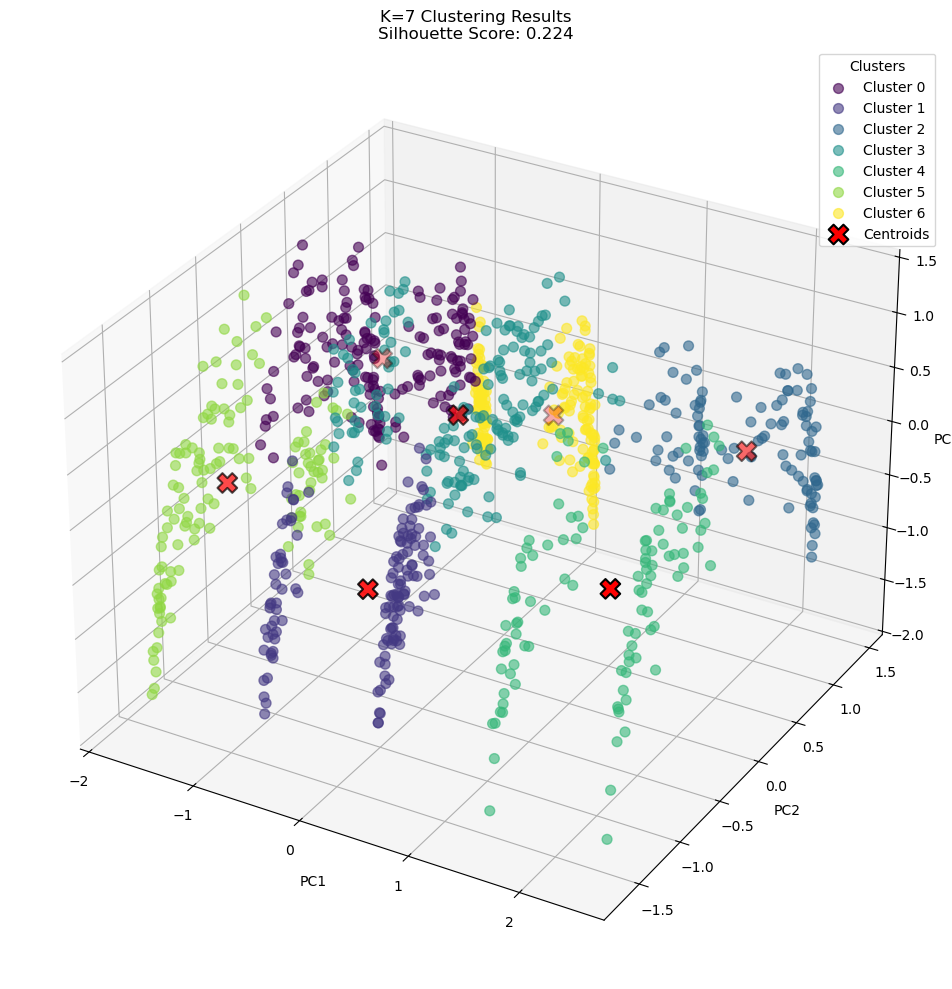

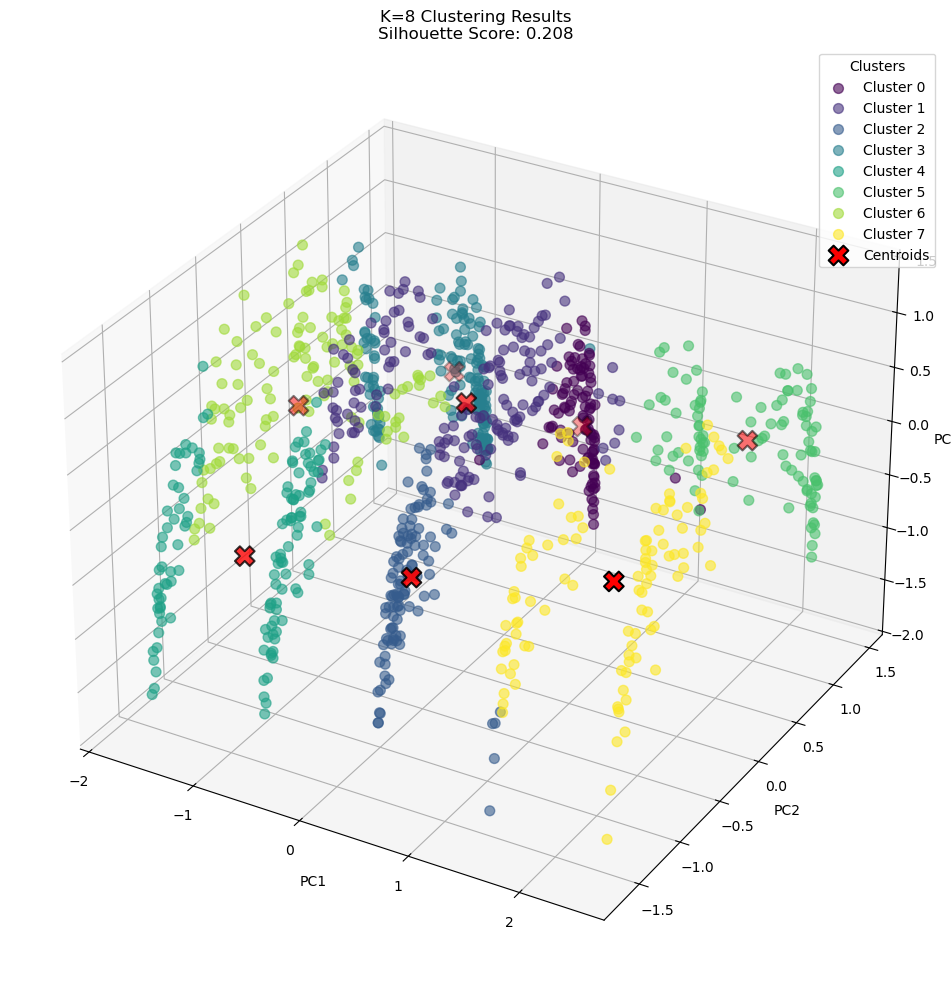

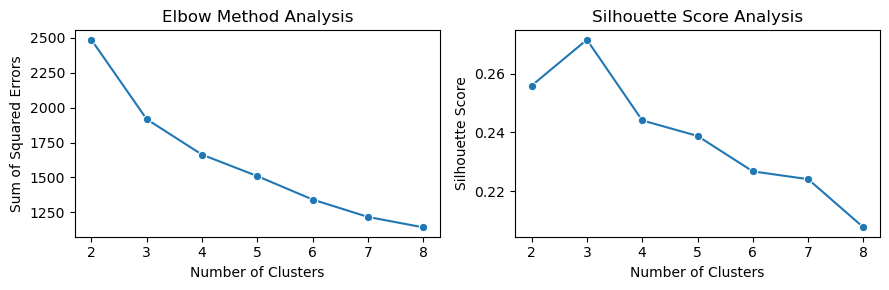

Optimal number of clusters: 3 (Silhouette Score: 0.272)


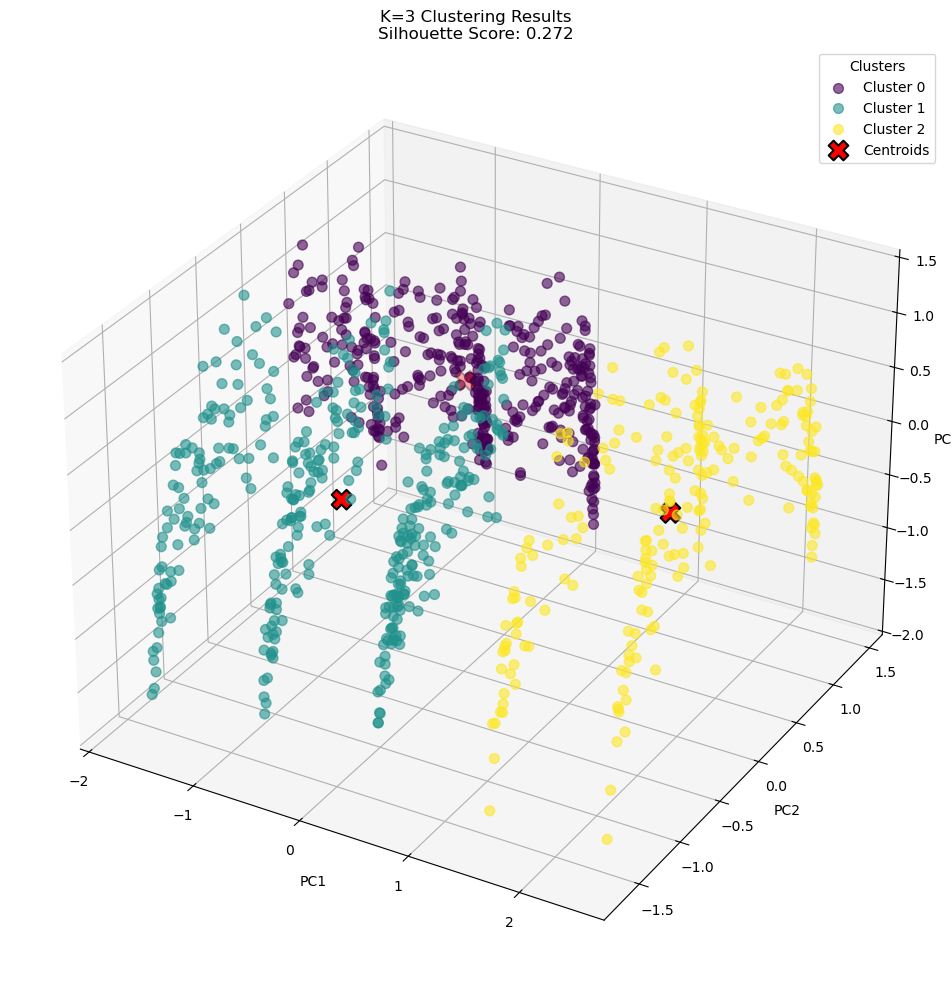

In [6]:
sse_values = []
silhouette_scores = []
results = {}

for k, job_name in training_jobs:
    try:
        # Retrieve model artifacts
        job_desc = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        model_path = job_desc['ModelArtifacts']['S3ModelArtifacts']

        # Download and extract model
        local_path = f'/tmp/model-k-{k}.tar.gz'
        boto3.client('s3').download_file(bucket, model_path.replace(f's3://{bucket}/', ''), local_path)
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')

        # Load model parameters
        model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = model_params[0].asnumpy()

        # Calculate cluster assignments
        distances = np.linalg.norm(data_np[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate metrics
        sse = np.sum((data_np - centroids[labels])**2)
        sil_score = silhouette_score(data_np, labels)
        sse_values.append(sse)
        silhouette_scores.append(sil_score)

        # Plot results for each k
        results[k] = (labels, centroids)
        plot_3D(data_np, labels, centroids, f'K={k} Clustering Results')

    except Exception as e:
        print(f'Error processing K={k}: {str(e)}')

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sns.lineplot(x=k_values, y=sse_values, marker='o', ax=ax1)
ax1.set_title('Elbow Method Analysis')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squared Errors')

sns.lineplot(x=k_values, y=silhouette_scores, marker='o', ax=ax2)
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Select optimal K
best_k = k_values[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})')

plot_3D(data_np, results[best_k][0], results[best_k][1], f'K={best_k} Clustering Results')